## Bike sharing demain prediction
Задача с kaggle: <a href='https://www.kaggle.com/competitions/bike-sharing-demand/overview'>Bike Sharing Demand</a>.
<br/>Описание задачи:
<br/>Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

### EDA
#### Описание данных с kaggle

<br/>You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

<br/>Data Fields
* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals

Целевая переменная для предсказания: count - количество аренд велосипедов

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#### Начнем с загрузки данных и изучения их заполненности (нет ли пропусков, дупликатов и т.п.)

In [2]:
df_train = pd.read_csv('data/train.csv', sep=',')

# взлянем на данные
df_train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
df_test = pd.read_csv('data/test.csv', sep=',')

# взлянем на данные
df_test.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [4]:
df_train.tail(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


In [5]:
# есть ли незаполненные значения?
df_train.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [6]:
df_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [7]:
# есть ли дупликаты
df_train.drop_duplicates().shape, df_train.shape

((10886, 12), (10886, 12))

Как видно из первого взгляда, все данные заполнены, пропусков нет. Поэтому первичная обработка - борьба с пропусками, удаление дупликатов не требуется. 
<br/>Признаки: <b>season, holiday, workingday, weather</b> - категориальные. Остальные признаки - вещественные
<br/>Признаки: <b>casual, registered</b> в сумме дают <b>count</b>, при прогнозе они будут недоступны. (в данных test их нет). Поэтому в дальнейшем исключим их из обучения в модели. Однако, их можно рассмотреть на этапе анализа.
<br/>Стоит разобрать дату и время: выделить час, день, месяц, год, а также время от начальной даты в данных.

In [8]:
df_train['datetime']

0        2011-01-01 00:00:00
1        2011-01-01 01:00:00
2        2011-01-01 02:00:00
3        2011-01-01 03:00:00
4        2011-01-01 04:00:00
                ...         
10881    2012-12-19 19:00:00
10882    2012-12-19 20:00:00
10883    2012-12-19 21:00:00
10884    2012-12-19 22:00:00
10885    2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: object

In [9]:
from datetime import datetime

# распарсим время на час, день, год, месяц, а также посчитаем время в часах от начала записей данных и какой 
# в записи день от начала года 

datetime_col = pd.to_datetime(df_train['datetime'])
datetime_start = datetime_col.iloc[0]
df_train['hour'] = datetime_col.dt.hour
df_train['year'] = datetime_col.dt.year
df_train['day'] = datetime_col.dt.day
df_train['month'] = datetime_col.dt.month

df_train['total_hours'] = (datetime_col - datetime_start).dt.total_seconds() / 3600.0
df_train['day_of_year'] = datetime_col.dt.dayofyear

#### Соотношения и распределения признаков и таргета


<AxesSubplot:xlabel='count', ylabel='Count'>

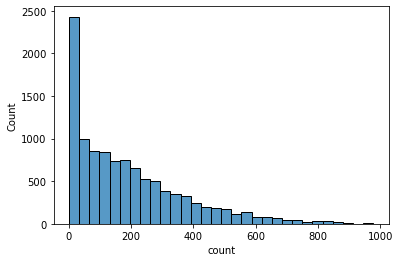

In [10]:
# Распределение целевой переменной
sns.histplot(df_train['count'], bins=30)

Судя по виду, распределение таргета имеет характер логнормального: много небольших значений и тяжелый хвост. Имеет смысл привести его к более "нормальному", применив преобразование $log(y + 1)$ 

<AxesSubplot:xlabel='count_log1p', ylabel='Count'>

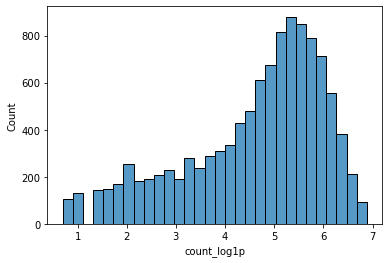

In [11]:
df_train['count_log1p'] = np.log1p(df_train['count'])

# Распределение целевой переменной
sns.histplot(df_train['count_log1p'], bins=30)

Посмотрим на распределения числовых признаков:

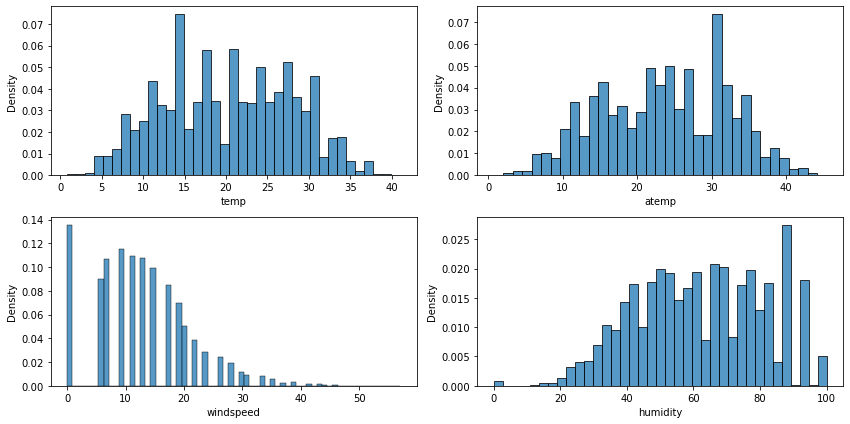

In [31]:
cols = ['temp', 'atemp', 'windspeed', 'humidity']

n_cols = 2
n_rows = int(np.ceil(len(cols)/n_cols))

fig = plt.figure(figsize=(n_cols*6, n_rows*3))

for ix, col in enumerate(cols):
    ax = fig.add_subplot(n_rows, n_cols, ix+1)
    sns.histplot(ax=ax, data=df_train, x=col, stat="density", common_norm=False)
fig.tight_layout()

Посмотрим на корелляционную матрицу:

<AxesSubplot:>

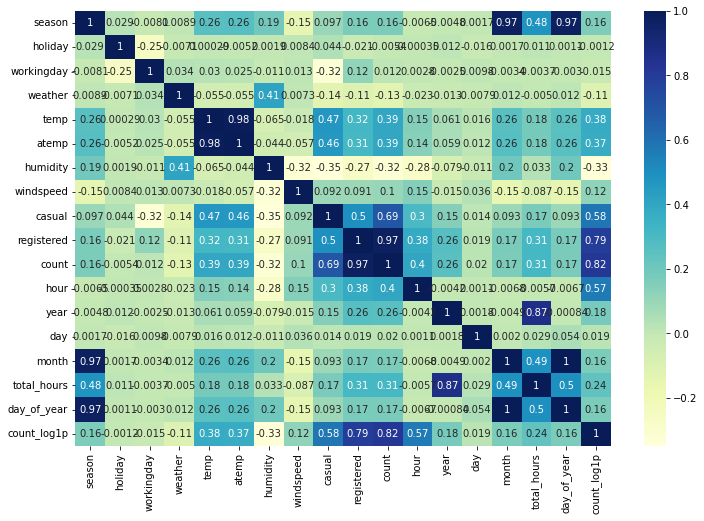

In [12]:
# Корелляционная матрица
fig = plt.figure(100, figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(df_train.corr(), ax=ax, cmap="YlGnBu", annot=True)

Посмотрим на распределения целевой переменной и признаков:

In [13]:
cat_cols = ['season', 'holiday', 'workingday', 'weather', 'year']
num_cols = ['temp', 'atemp', 'windspeed', 'humidity', 'month', 'hour', 'total_hours', 'day']
target = 'count_log1p'

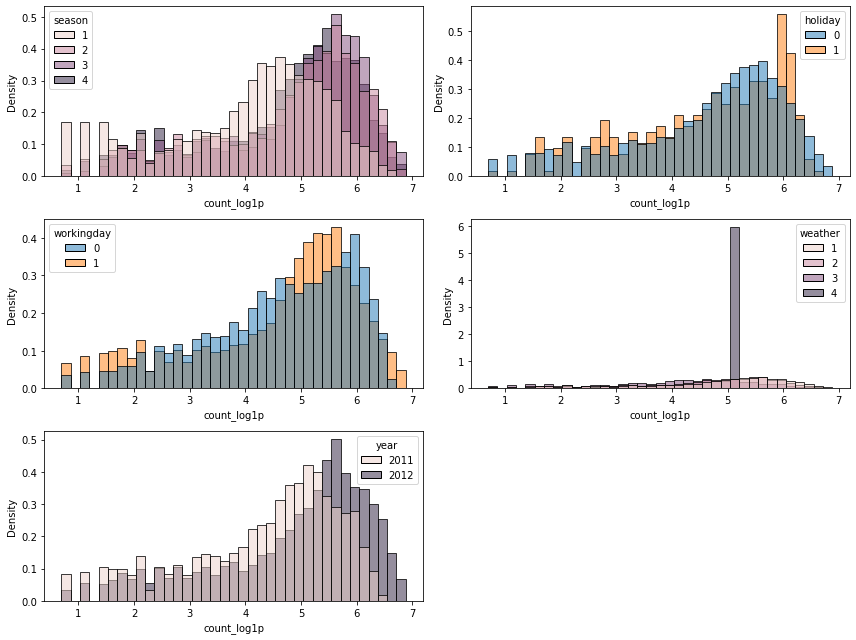

In [14]:
## по категориальным признакам построим графики по count_log1p:

n_cols = 2
n_rows = int(np.ceil(len(cat_cols)/n_cols))

fig = plt.figure(figsize=(n_cols*6, n_rows*3))

for ix, col in enumerate(cat_cols):
    ax = fig.add_subplot(n_rows, n_cols, ix+1)
    sns.histplot(ax=ax, data=df_train, x='count_log1p', hue=col, stat="density", common_norm=False)
fig.tight_layout()

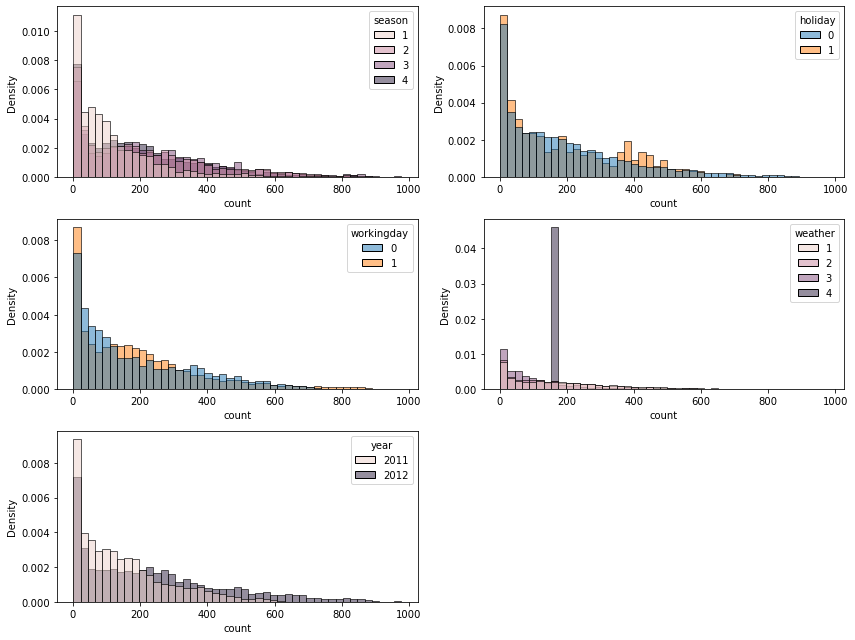

In [15]:
## по категориальным признакам построим графики по count:

n_cols = 2
n_rows = int(np.ceil(len(cat_cols)/n_cols))

fig = plt.figure(figsize=(n_cols*6, n_rows*3))

for ix, col in enumerate(cat_cols):
    ax = fig.add_subplot(n_rows, n_cols, ix+1)
    sns.histplot(ax=ax, data=df_train, x='count', hue=col, stat="density", common_norm=False)
fig.tight_layout()

In [16]:
#В распределении по типам погоды присутствует выброс для типа 4. Повнимательнее посмотрим на данные для типа погоды 4:
df_train.loc[df_train['weather'] == 4]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,year,day,month,total_hours,day_of_year,count_log1p
5631,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164,18,2012,9,1,8970.0,9,5.105945


In [18]:
# Тип погоды 4 встречался один раз. Отсюда и выброс в распределениях.

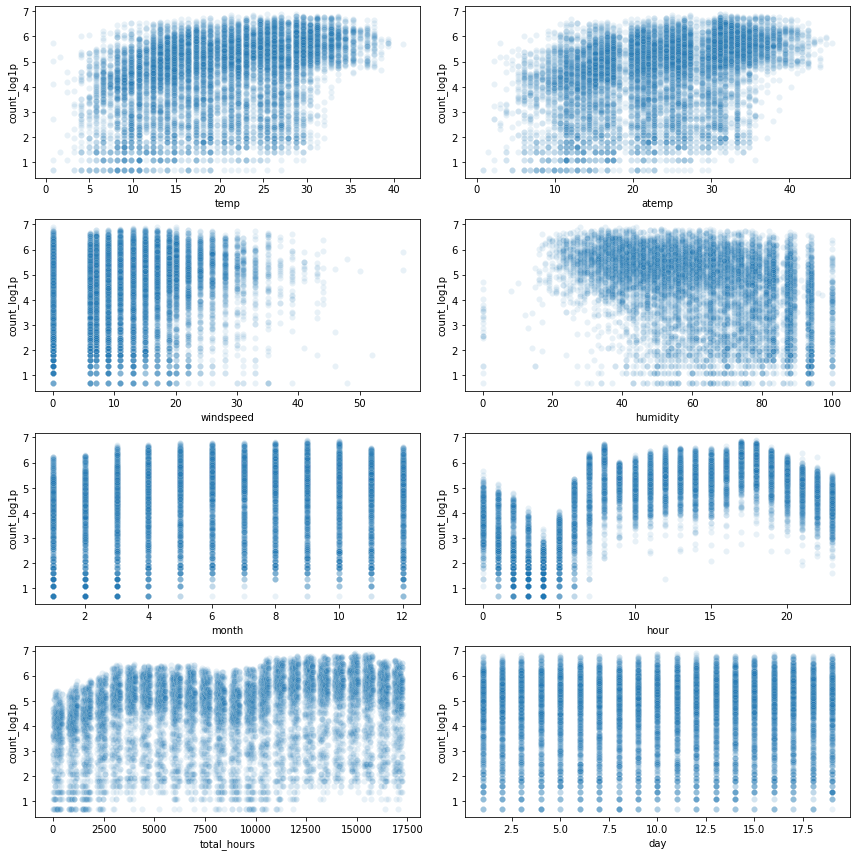

In [17]:
## по вещественным признакам построим графики:

n_cols = 2
n_rows = int(np.ceil(len(num_cols)/n_cols))

fig = plt.figure(figsize=(n_cols*6, n_rows*3))

for ix, col in enumerate(num_cols):
    ax = fig.add_subplot(n_rows, n_cols, ix+1)
    sns.scatterplot(ax=ax, data=df_train, x=col, y='count_log1p', alpha=0.1)
fig.tight_layout()

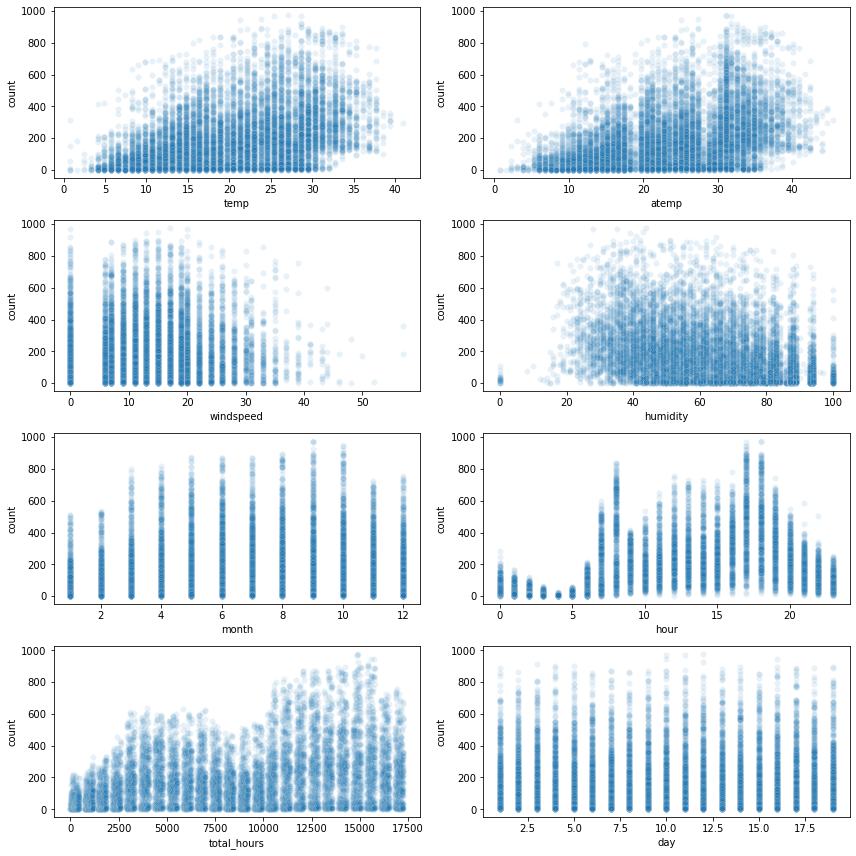

In [19]:
## по вещественным признакам построим графики:

n_cols = 2
n_rows = int(np.ceil(len(num_cols)/n_cols))

fig = plt.figure(figsize=(n_cols*6, n_rows*3))

for ix, col in enumerate(num_cols):
    ax = fig.add_subplot(n_rows, n_cols, ix+1)
    sns.scatterplot(ax=ax, data=df_train, x=col, y='count', alpha=0.1)
fig.tight_layout()

<AxesSubplot:xlabel='month', ylabel='count'>

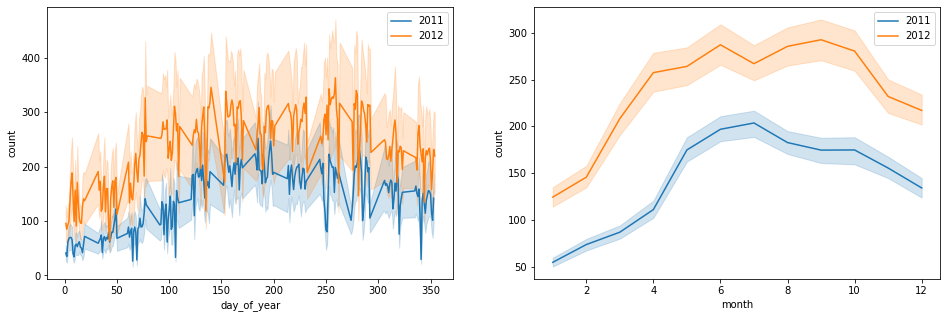

In [20]:
## Изменение целевой переменной по счетчику часов с начала записи:

fig = plt.figure(figsize=(2*8, 1*5))
ax = fig.add_subplot(1, 2, 1)
sns.lineplot(ax=ax, data=df_train.loc[df_train['year'] == 2011], x="day_of_year", y="count", label='2011')
sns.lineplot(ax=ax, data=df_train.loc[df_train['year'] == 2012], x="day_of_year", y="count", label='2012')

ax = fig.add_subplot(1, 2, 2)
sns.lineplot(ax=ax, data=df_train.loc[df_train['year'] == 2011], x="month", y="count", label='2011')
sns.lineplot(ax=ax, data=df_train.loc[df_train['year'] == 2012], x="month", y="count", label='2012')

Выводы по анализу:
- из-за особенностей распределения таргета (близко к логнормальному) можно в обучении использовать логарифмированное значение;
- присутствуют отличия в распределениях таргета по году, погоде, выходным/рабочим дням, и праздничный ли день;
- присутствуют сезонность по дате, и по времени суток (часу);
- по числовым признакам явно есть не слишком сильная зависимость от таргета у всех;
- есть только одно наблюдение по погоде 4. При кодировании признака погоды следует это учесть.

#### Получение дополнительных признаков
Какие еще признаки из имеющихся можно добыть:
- разница температур (реальная - ощущаемая) - преполагается, что чем она выше, тем сильнее ветер и выше влажность, т.е. менее комфортно кататься;
- достать время захода и восхода за год, и тем самым определить темное время суток (в темное время меньше используют велосипед).

Достанем время захода и восхода по дням с сайта <a href='https://www.timeanddate.com/sun/usa/washington-dc?month=1&year=2024'>https://www.timeanddate.com/</a> для Washington DC

In [21]:
import re

months = list(range(1, 13))

sun_moon = pd.DataFrame()

for m in months:
    url = f'https://www.timeanddate.com/sun/usa/washington-dc?month={m}&year=2024'

    tables = pd.read_html(url)
    temp = tables[1].copy()
    temp.columns = temp.columns.droplevel(-1)
    temp.columns = temp.columns.map(':'.join).str.strip(':')
    temp = temp.rename(columns={temp.columns[0]: 'day'})
    temp = temp[['day', 'Civil Twilight:Start', 'Civil Twilight:End']]
    temp = temp.iloc[:-1]
    temp['month'] = [m]*temp.shape[0]
    sun_moon = pd.concat([sun_moon, temp])

# переиндексируем датафрейм и выкинем лишнее в колонке day
sun_moon = sun_moon.reset_index(drop=True)
sun_moon = sun_moon.loc[sun_moon['day'].apply(lambda x: re.match('Note', x) is None)]
sun_moon['day'] = sun_moon['day'].astype(int)

In [22]:
# Преобразуем время восхода и заката в формат часов с дробной частью
dt_sunmoon_st = pd.to_datetime(sun_moon['Civil Twilight:Start'])
dt_sunmoon_end = pd.to_datetime(sun_moon['Civil Twilight:End'])

sun_moon['twilight_start_hour'] = dt_sunmoon_st.dt.hour.astype(float)
sun_moon['twilight_start_hour'] = sun_moon['twilight_start_hour'] + dt_sunmoon_st.dt.minute.astype(float)/60.0

sun_moon['twilight_end_hour'] = dt_sunmoon_end.dt.hour.astype(float)
sun_moon['twilight_end_hour'] = sun_moon['twilight_end_hour'] + dt_sunmoon_end.dt.minute.astype(float)/60.0

sun_moon = sun_moon.drop(['Civil Twilight:Start', 'Civil Twilight:End'], axis=1)

In [23]:
sun_moon.to_csv('data/twilight_time.csv', sep=',')

In [24]:
# смержим данные по времени заката с исходной таблицей

df_train = df_train.merge(sun_moon, how='left', on=['month', 'day'])
df_train['is_daylight'] = ((df_train['twilight_start_hour'] < df_train['hour']) &
                            (df_train['twilight_end_hour'] > df_train['hour'])).replace({True: 1, False: 0})

In [25]:
df_train['d_temp'] = df_train['temp'] - df_train['atemp']

В результате определили 2 признака: 
- is_daylight - признак светлого времени суток
- d_temp - разница реальной и ощащаемой температур

<br/>Построим распределения таргетов по этим признакам:

<AxesSubplot:xlabel='d_temp', ylabel='count'>

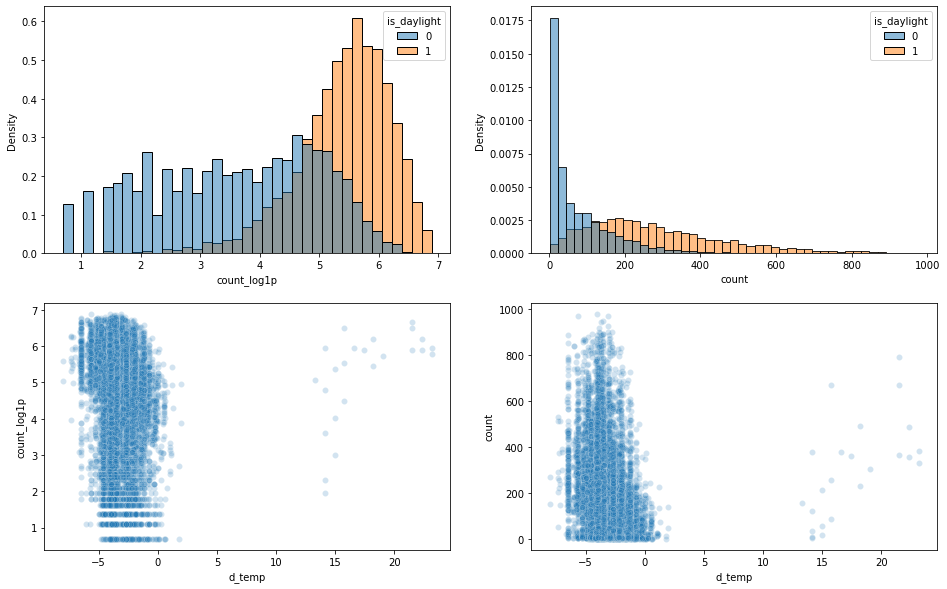

In [26]:
fig = plt.figure(figsize=(2*8, 2*5))
ax = fig.add_subplot(2, 2, 1)
sns.histplot(ax=ax, data=df_train, x='count_log1p', hue='is_daylight', stat="density", common_norm=False)
ax = fig.add_subplot(2, 2, 2)
sns.histplot(ax=ax, data=df_train, x='count', hue='is_daylight', stat="density", common_norm=False)
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(ax=ax, data=df_train, x='d_temp', y='count_log1p', alpha=0.2)
ax = fig.add_subplot(2, 2, 4)
sns.scatterplot(ax=ax, data=df_train, x='d_temp', y='count', alpha=0.2)

Признак 'is_daylight' дает очень хорошее разделение. Вплоть до различных по форме распределений. По признаку d_temp явно не видна зависимость, однако из-за сильной скореллированности temp и a_temp можно использовать d_temp вместо a_temp.

### Выводы по EDA
- предобработка данных: заполнение пропусков удаление дубликатов не требуется;
- из-за характера распределения таргета (близкое к экспоненциальному или логнормальному) имеет смысл перейти к логарифму таргета;
- для определения сезонности и тренда распарсим дату и время datetime, сезонность наблюдается как по дате, так и по времени суток. По году также видны сильные отличия. Выделим из datetime год, час, месяц и день от начала года (с ним можно поработать как с временным рядом); 
- из категориальных признаков имеет смысл взять все т.к. они дают видимое отличие в распределениях таргета;
- по числовым признакам есть смысл рассмотреть все, но из-за сильной скореллированности реальной и ощущаемой температуры нужно перейти к разнице этих температур;
- в дополнение к имеющимся признакам есть смысл взять признак разницы температур и признак светлого времени суток. Последний дает очень хорошее разделение таргета.